In [2]:
import numpy as np
import mne
import matplotlib.pyplot as plt
from pyESN import ESN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [3]:
schizophrenic_epochs = mne.read_epochs(
    'processed_schizophrenic_eeg-epo.fif', preload=True)

healthy_epochs = mne.read_epochs('processed_healthy_eeg-epo.fif', preload=True)

Reading d:\research-reservoir\Schizo-hormone\processed_schizophrenic_eeg-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    1996.00 ms
        0 CTF compensation matrices available
Not setting metadata
15819 matching events found
No baseline correction applied
0 projection items activated
Reading d:\research-reservoir\Schizo-hormone\processed_healthy_eeg-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    1996.00 ms
        0 CTF compensation matrices available
Not setting metadata
13016 matching events found
No baseline correction applied
0 projection items activated


In [4]:
data = schizophrenic_epochs.get_data()  
n_epochs, n_channels, n_times = data.shape

data_reshaped = data.reshape(n_epochs, -1)


scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_reshaped)

data_scaled = data_scaled.reshape(n_epochs, n_channels, n_times)

C:\Users\anisr\AppData\Local\Temp\ipykernel_10720\2129877070.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = schizophrenic_epochs.get_data()


In [5]:
data_reshaped.shape

(15819, 9500)

In [13]:
import numpy as np
from reservoirpy.nodes import ESN
from reservoirpy.observables import rmse, nrmse
from scipy.stats import zscore

n_epochs, n_channels, n_times = data_scaled.shape
n_inputs = n_channels * n_times
n_outputs = n_channels * n_times

params = {
    'n_reservoir': 500,
    'spectral_radius': 0.95,
    'sparsity': 0.1,
    'leak_rate': 0.5,
    'input_scaling': 0.5,
    'input_shift': 0.0
}

esn = ESN(
    units=params['n_reservoir'],
    lr=params['leak_rate'],
    sr=params['spectral_radius'],
    input_scaling=params['input_scaling'],
    input_shift=params['input_shift'],
    input_dim=n_inputs,
    output_dim=n_outputs,
    sparsity=params['sparsity']
)

X = data_scaled.reshape(n_epochs, -1) 
y = np.roll(X, -1, axis=0)  
X = X[:-1]  
y = y[:-1]  

X = zscore(X, axis=0)

esn.fit(X, y)

Running ESN-1: 100%|██████████| 1/1 [00:19<00:00, 19.28s/it]


Fitting node ESN-1...


'ESN-1': ESN('Reservoir-1', 'Ridge-1')

In [14]:
n_predictions = 100

last_known_epoch = X[-1]

def predict_future_epochs(esn, input_data, n_predictions):
    predictions = []
    current_input = input_data.reshape(1, -1)

    for _ in range(n_predictions):
        next_prediction = esn(current_input)
        predictions.append(next_prediction.flatten())
        current_input = next_prediction

    return np.array(predictions)

future_predictions = predict_future_epochs(
    esn, last_known_epoch, n_predictions)

future_predictions = future_predictions.reshape(-1, n_channels, n_times)

In [9]:
# import numpy as np
# from reservoirpy.nodes import ESN
# from reservoirpy.observables import rmse, nrmse
# from sklearn.model_selection import TimeSeriesSplit
# from scipy.stats import zscore

# n_epochs, n_channels, n_times = data_scaled.shape
# n_inputs = n_channels * n_times
# n_outputs = n_channels * n_times


# def create_esn(n_inputs, n_outputs, n_reservoir, spectral_radius, sparsity, leak_rate, input_scaling, input_shift):
#     return ESN(
#         units=n_reservoir,
#         lr=leak_rate,
#         sr=spectral_radius,
#         input_scaling=input_scaling,
#         input_shift=input_shift,
#         input_dim=n_inputs,
#         output_dim=n_outputs,
#         sparsity=sparsity
#     )


# def train_and_evaluate_esn(X_train, y_train, X_val, y_val, params):
#     esn = create_esn(n_inputs, n_outputs, **params)
#     esn = esn.fit(X_train, y_train)

#     y_pred = np.zeros_like(y_val)
#     for i in range(len(X_val)):
#         y_pred[i] = esn(X_val[i].reshape(1, -1))

#     return nrmse(y_val, y_pred)


# param_ranges = {
#     'n_reservoir': [500, 1000],
#     'spectral_radius': [0.9, 0.95],
#     'sparsity': [0.1, 0.2],
#     'leak_rate': [0.3, 0.5],
#     'input_scaling': [0.5, 1.0],
#     'input_shift': [0.0, 0.5]
# }

# X = data_scaled.reshape(n_epochs, -1)  
# y = np.roll(X, -1, axis=0)  
# X = X[:-1]  
# y = y[:-1] 

# X = zscore(X, axis=0)

# tscv = TimeSeriesSplit(n_splits=3)

# best_params = None
# best_score = np.inf

# for n_reservoir in param_ranges['n_reservoir']:
#     for spectral_radius in param_ranges['spectral_radius']:
#         for sparsity in param_ranges['sparsity']:
#             for leak_rate in param_ranges['leak_rate']:
#                 for input_scaling in param_ranges['input_scaling']:
#                     for input_shift in param_ranges['input_shift']:
#                         params = {
#                             'n_reservoir': n_reservoir,
#                             'spectral_radius': spectral_radius,
#                             'sparsity': sparsity,
#                             'leak_rate': leak_rate,
#                             'input_scaling': input_scaling,
#                             'input_shift': input_shift
#                         }

#                         scores = []
#                         for train_index, val_index in tscv.split(X):
#                             X_train, X_val = X[train_index], X[val_index]
#                             y_train, y_val = y[train_index], y[val_index]
#                             score = train_and_evaluate_esn(
#                                 X_train, y_train, X_val, y_val, params)
#                             scores.append(score)

#                         avg_score = np.mean(scores)
#                         if avg_score < best_score:
#                             best_score = avg_score
#                             best_params = params

# print("Best parameters:", best_params)
# print("Best score:", best_score)

# n_ensemble = 3
# ensemble = [create_esn(n_inputs, n_outputs, **best_params)
#             for _ in range(n_ensemble)]

# for esn in ensemble:
#     esn.fit(X, y)

# def predict_ensemble(ensemble, input_data, n_predictions=100):
#     predictions = []
#     current_input = input_data.reshape(1, -1)

#     for _ in range(n_predictions):
#         ensemble_predictions = [esn(current_input) for esn in ensemble]
#         next_prediction = np.mean(ensemble_predictions, axis=0)
#         predictions.append(next_prediction.flatten())
#         current_input = next_prediction

#     return np.array(predictions)


# last_known_epoch = X[-1]
# future_predictions = predict_ensemble(ensemble, last_known_epoch)

# future_predictions = future_predictions.reshape(-1, n_channels, n_times)

In [15]:
from scipy.signal import welch


def compute_band_power(epoch, fs=250): 
    f, psd = welch(epoch, fs, nperseg=fs)
    bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30),
        'gamma': (30, 40)
    }

    powers = {}
    for band, (fmin, fmax) in bands.items():
        idx = np.logical_and(f >= fmin, f <= fmax)
        powers[band] = np.mean(psd[:, idx], axis=1)

    return powers


original_powers = [compute_band_power(epoch) for epoch in data_scaled[-100:]]
predicted_powers = [compute_band_power(epoch) for epoch in future_predictions]

for band in ['delta', 'theta', 'alpha', 'beta', 'gamma']:
    original_trend = [power[band] for power in original_powers]
    predicted_trend = [power[band] for power in predicted_powers]

    print(f"{band.capitalize()} band trend:")
    print(f"  Original: {np.mean(original_trend):.4f}")
    print(f"  Predicted: {np.mean(predicted_trend):.4f}")
    print(
        f"  Change: {(np.mean(predicted_trend) - np.mean(original_trend)) / np.mean(original_trend) * 100:.2f}%")
    print()

Delta band trend:
  Original: 0.0182
  Predicted: 0.0986
  Change: 440.66%

Theta band trend:
  Original: 0.0041
  Predicted: 0.0058
  Change: 41.20%

Alpha band trend:
  Original: 0.0173
  Predicted: 0.0023
  Change: -86.64%

Beta band trend:
  Original: 0.0016
  Predicted: 0.0011
  Change: -33.21%

Gamma band trend:
  Original: 0.0003
  Predicted: 0.0011
  Change: 220.33%



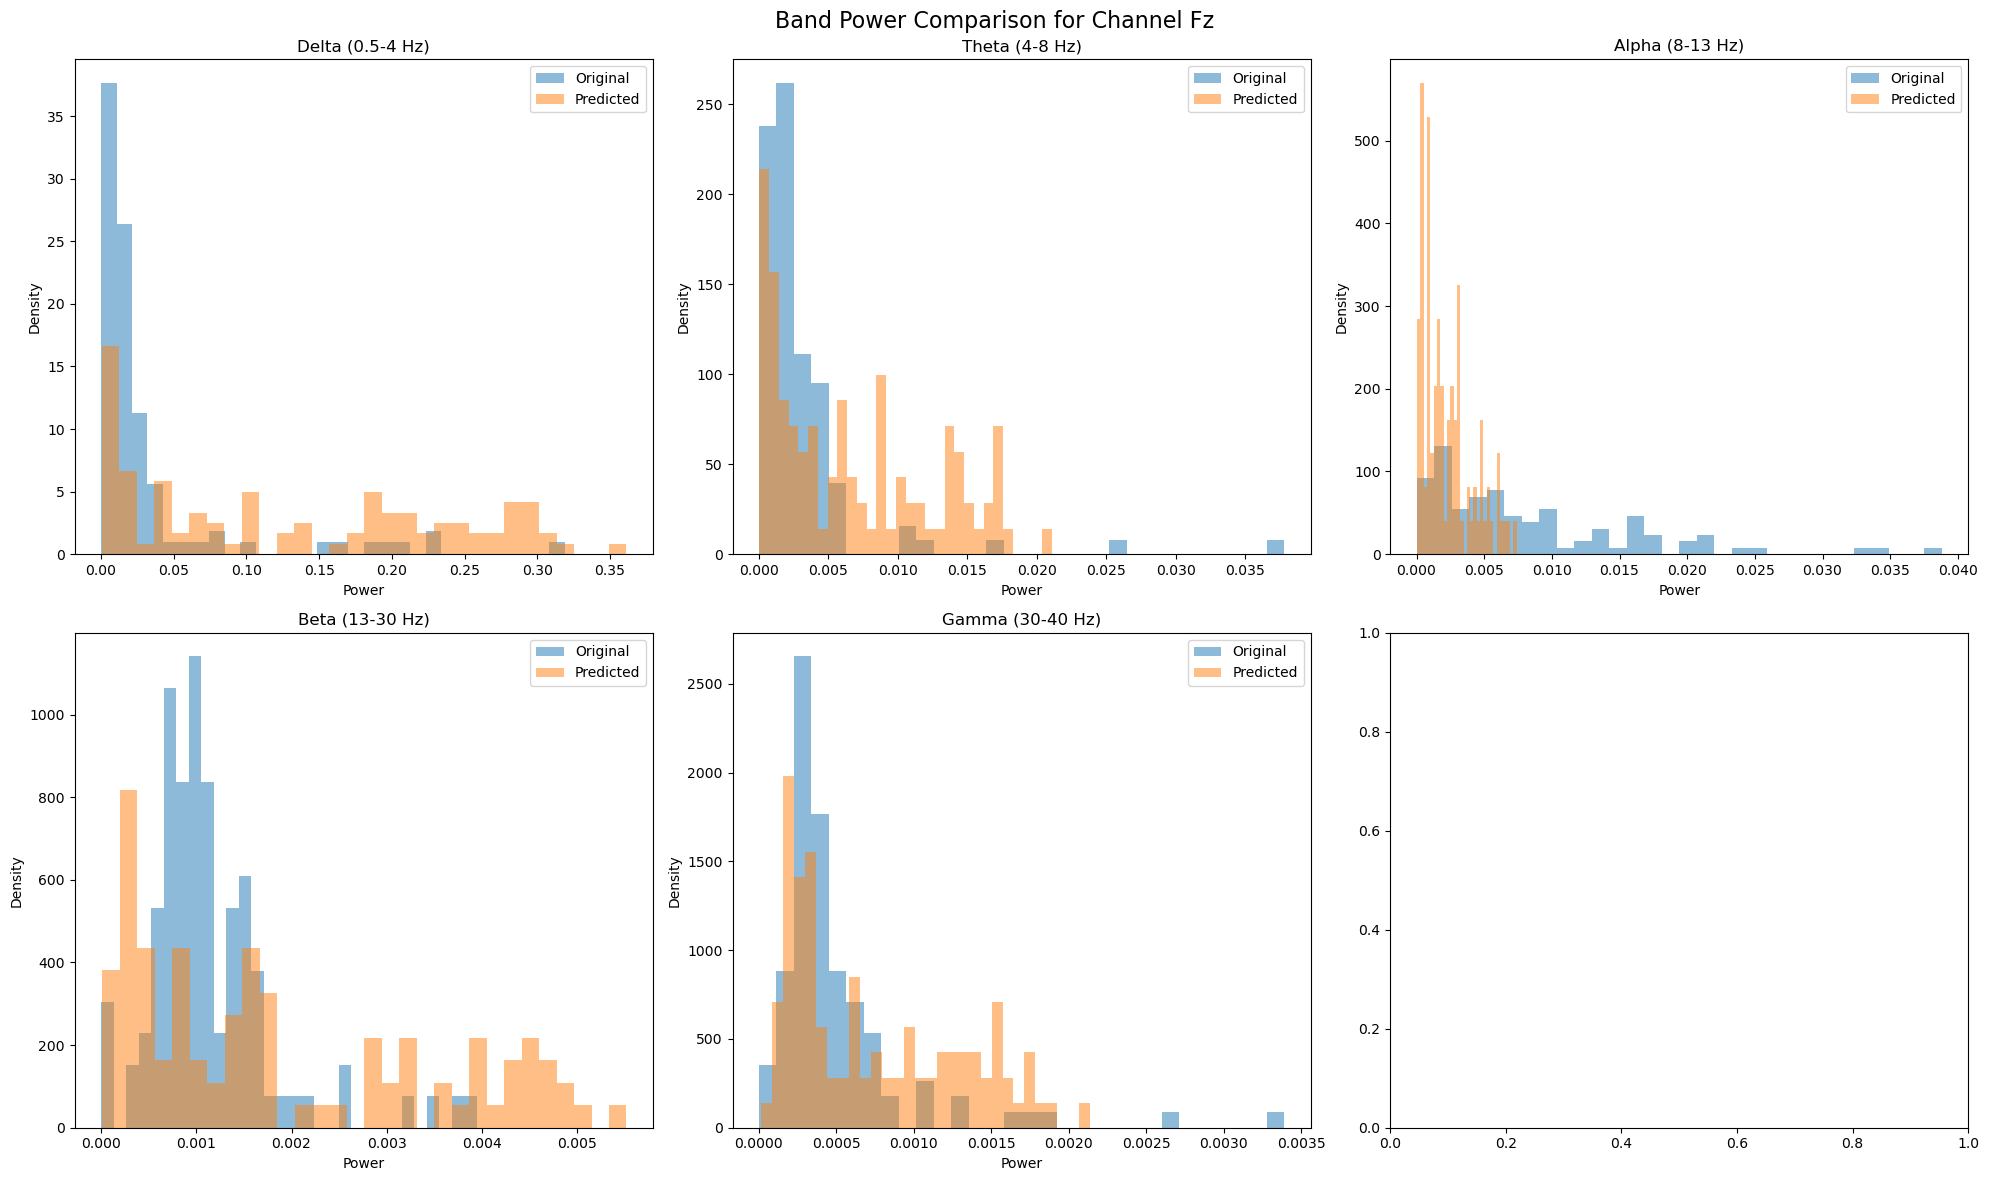

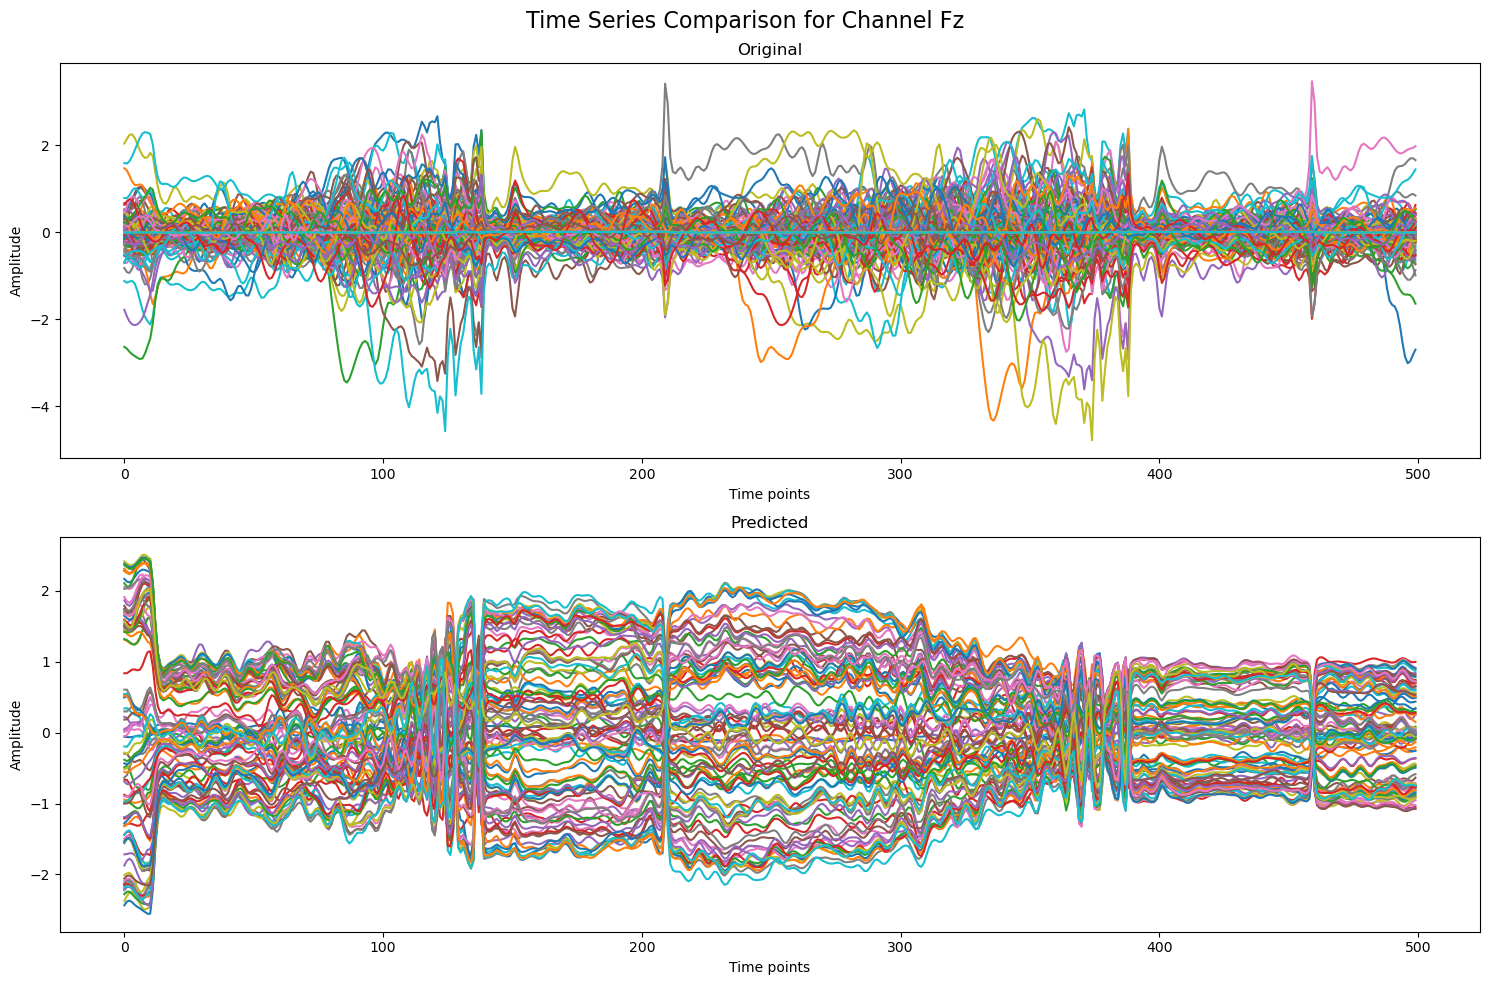

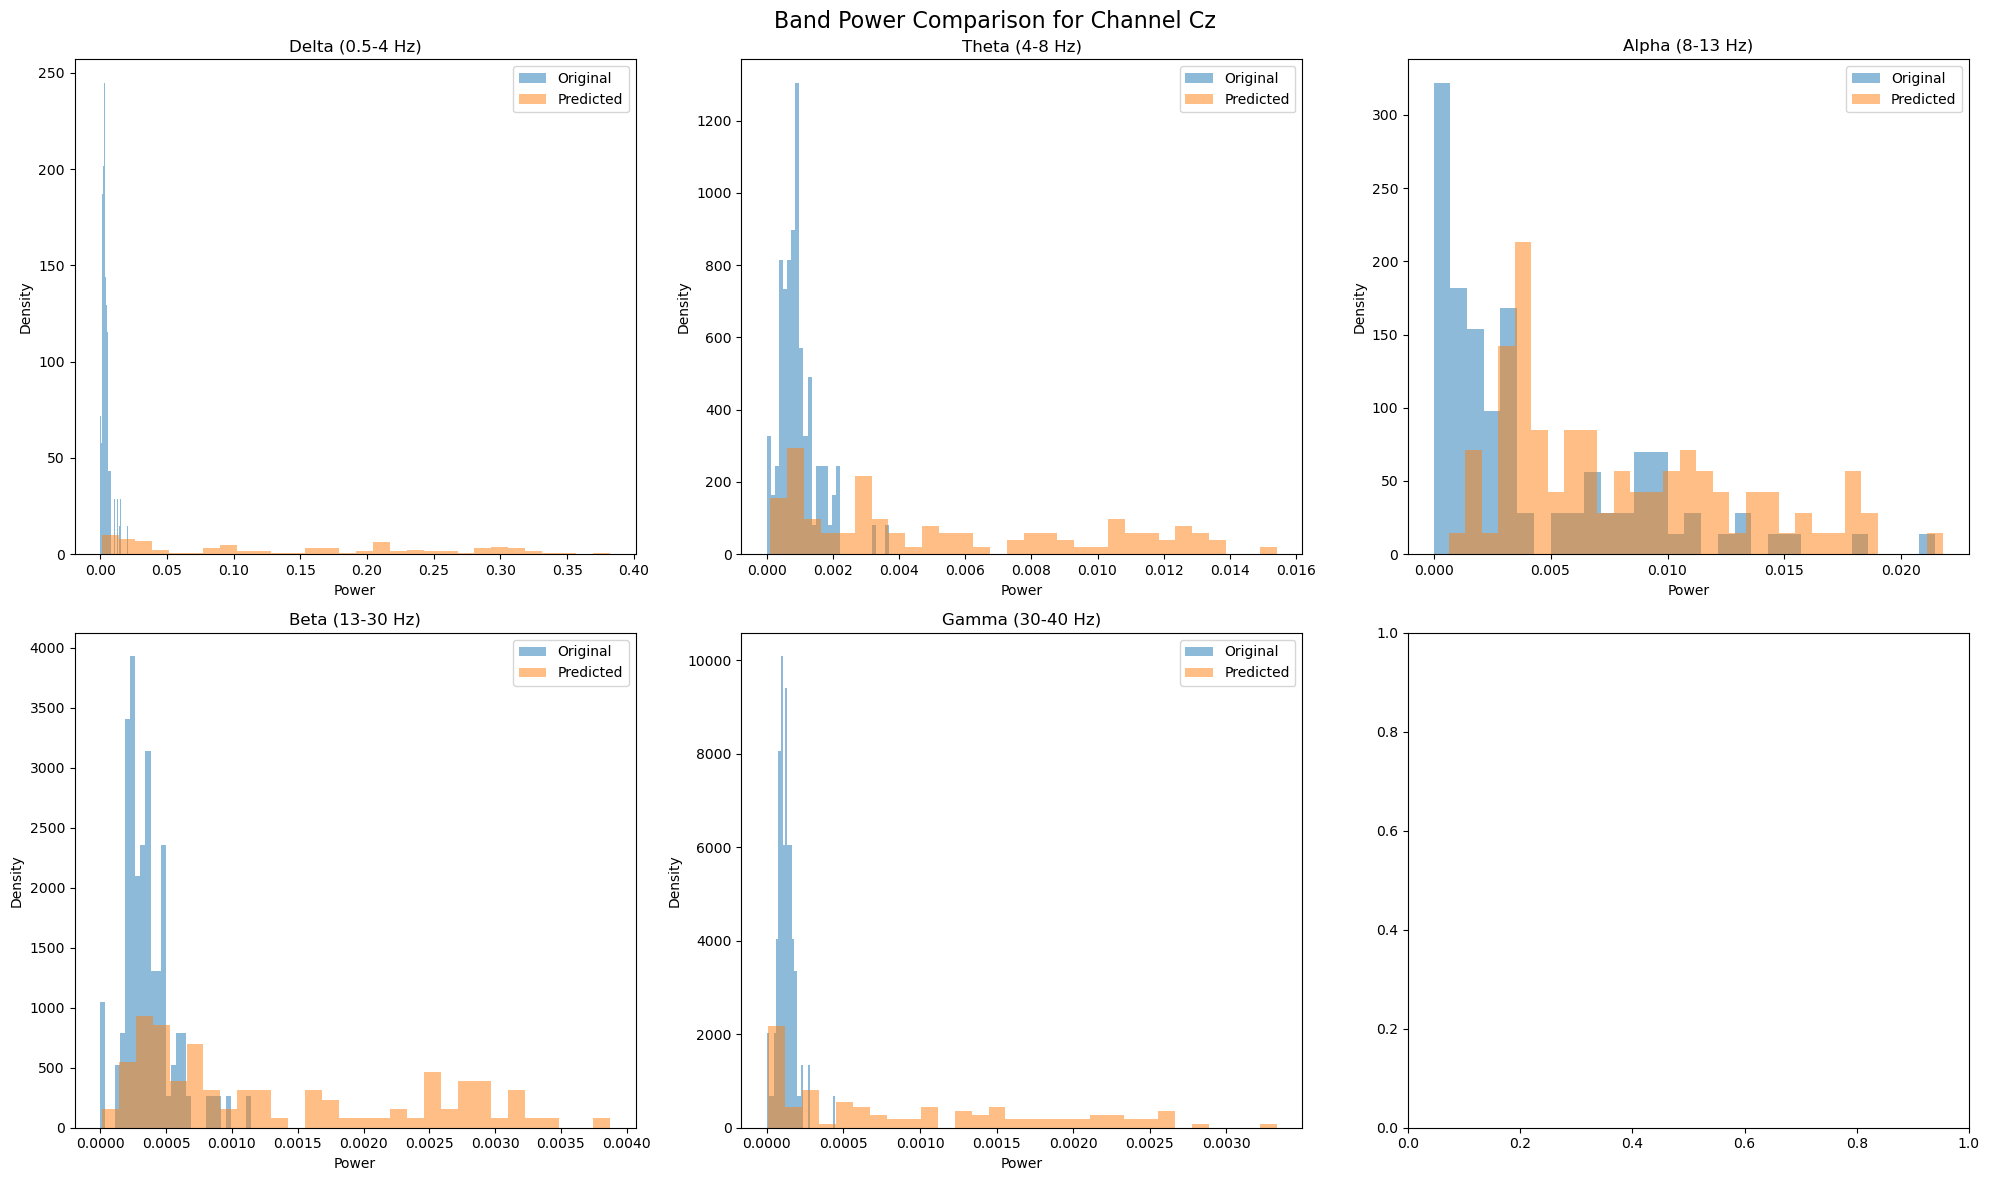

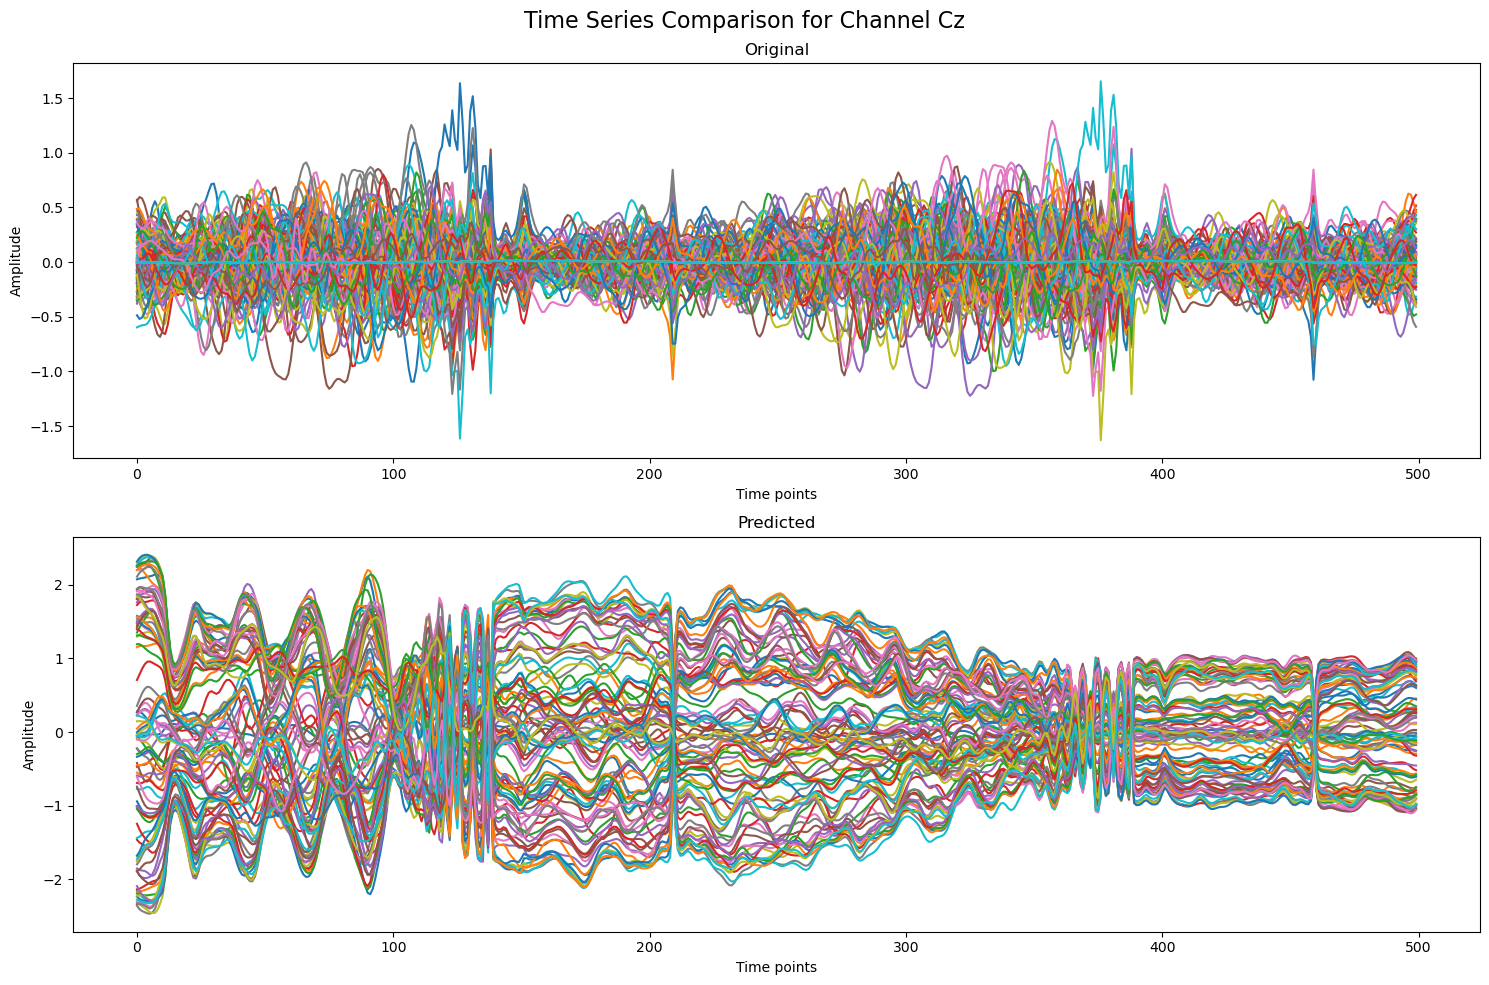

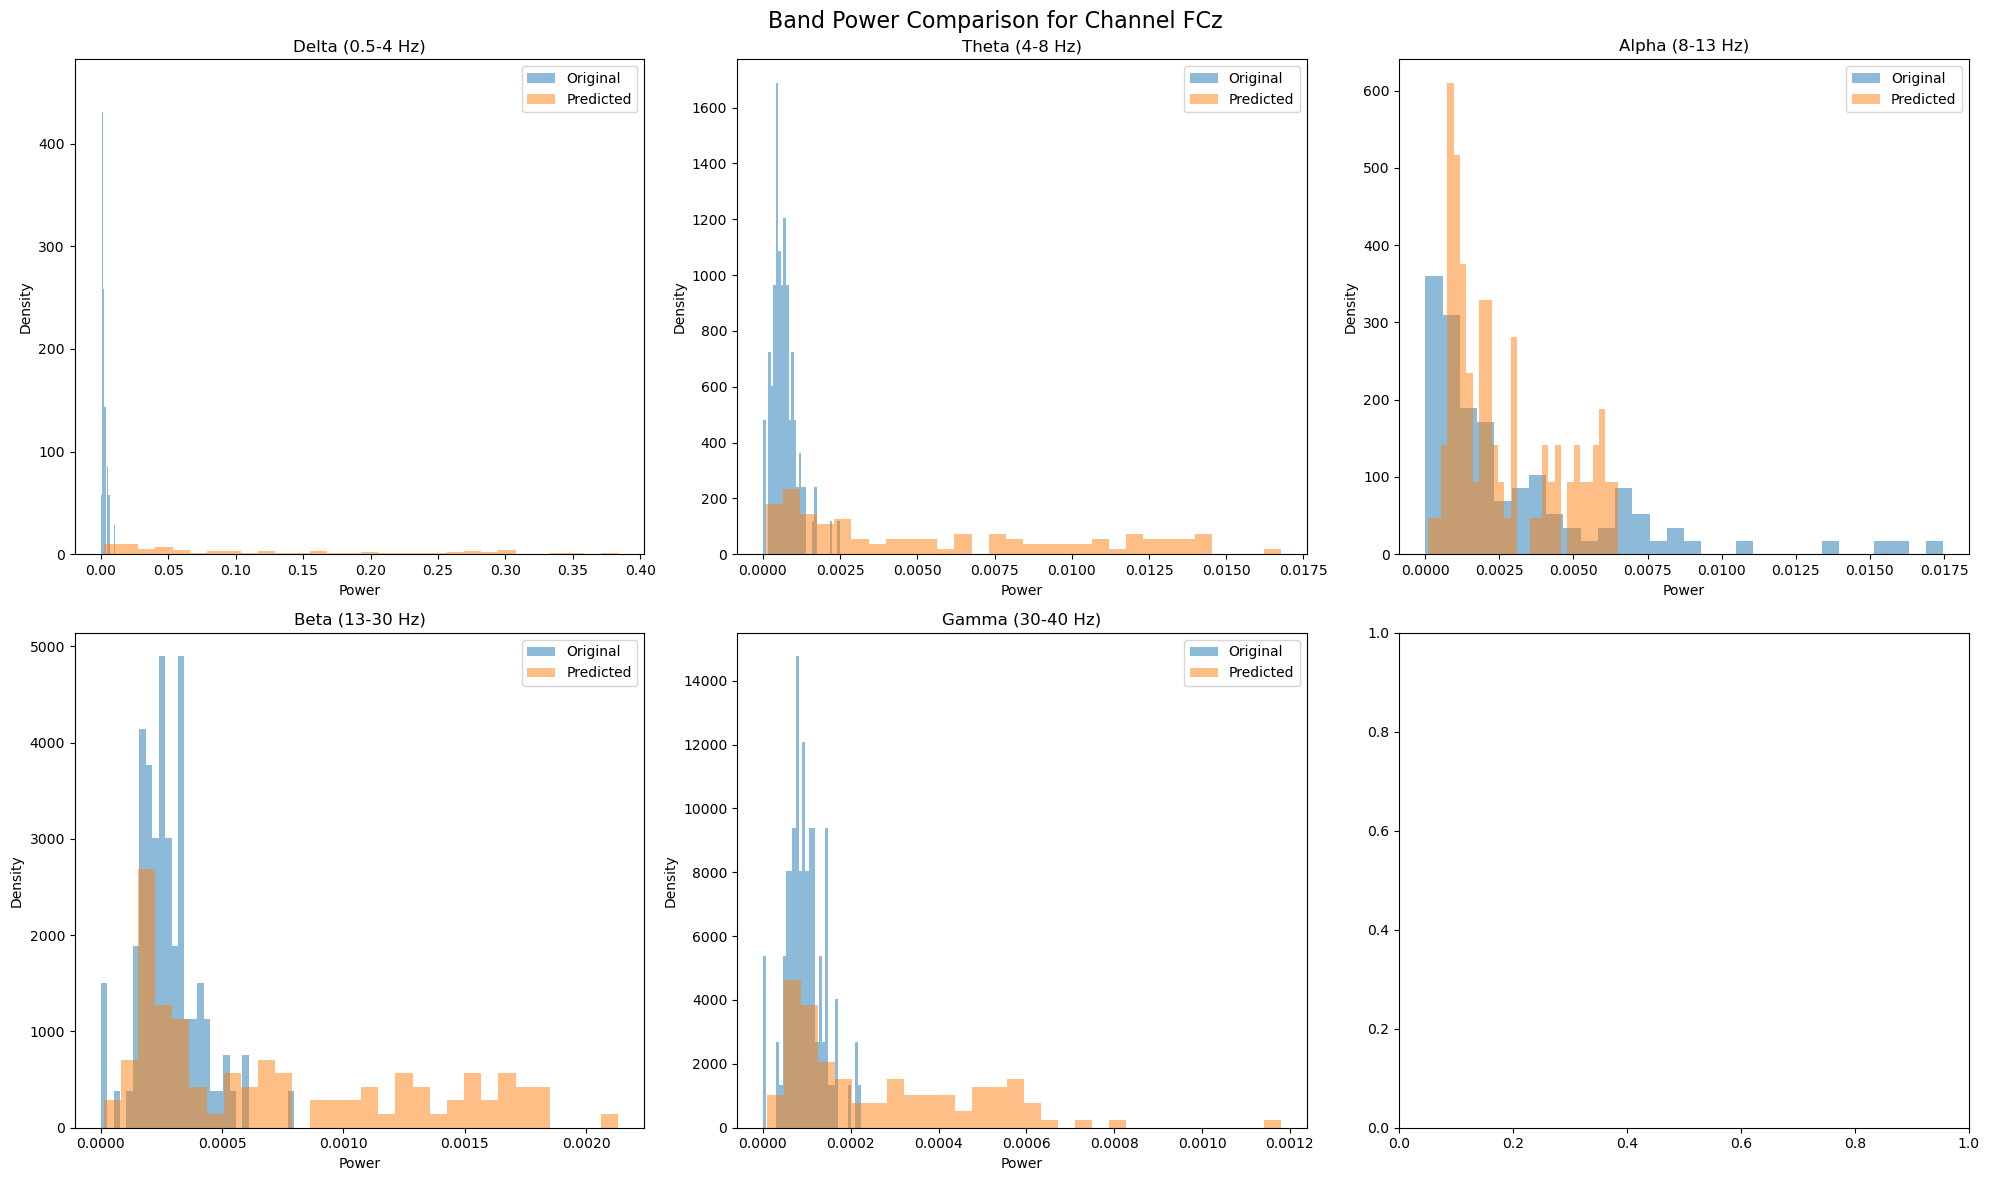

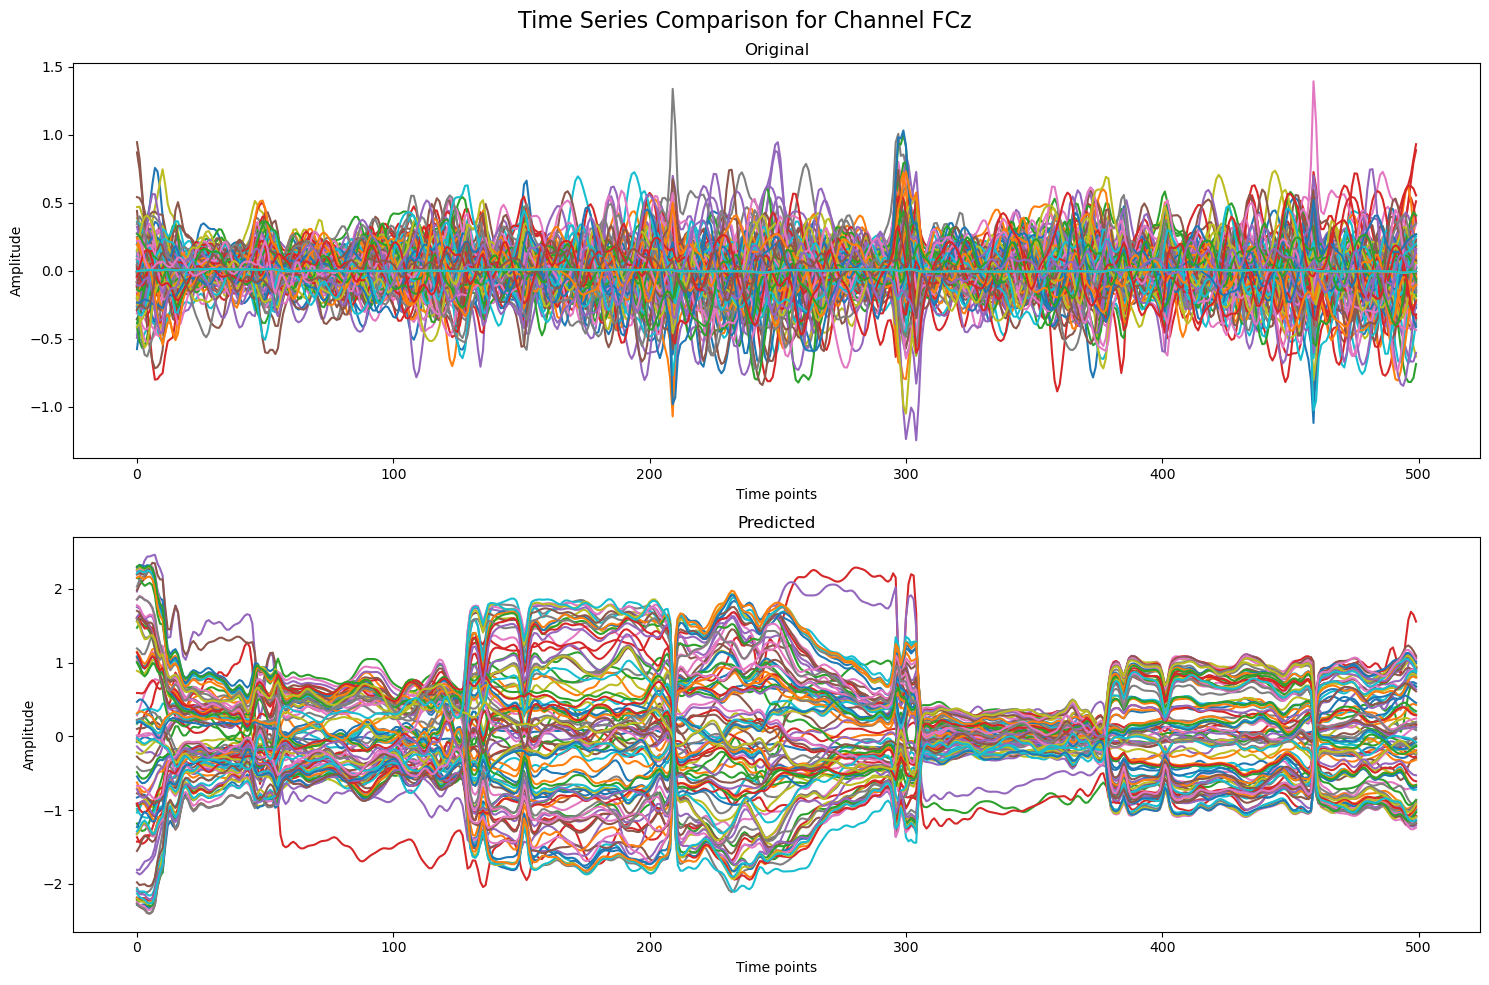

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

channel_names = ['Fz', 'Cz', 'FCz']
channel_indices = [2, 9, 4]  

bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 40)
}


def compute_band_power(data, fs=250):
    f, psd = welch(data, fs, axis=-1)
    powers = {}
    for band, (fmin, fmax) in bands.items():
        idx = np.logical_and(f >= fmin, f <= fmax)
        powers[band] = np.mean(psd[:, idx], axis=1)
    return powers


def plot_band_comparison(original, predicted, channel_name, channel_idx):
    orig_powers = compute_band_power(original[:, channel_idx, :])
    pred_powers = compute_band_power(predicted[:, channel_idx, :])

    fig, axs = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle(
        f'Band Power Comparison for Channel {channel_name}', fontsize=16)

    for i, (band, (fmin, fmax)) in enumerate(bands.items()):
        row = i // 3
        col = i % 3

        axs[row, col].hist(orig_powers[band], bins=30,
                           alpha=0.5, label='Original', density=True)
        axs[row, col].hist(pred_powers[band], bins=30,
                           alpha=0.5, label='Predicted', density=True)

        axs[row, col].set_title(f'{band.capitalize()} ({fmin}-{fmax} Hz)')
        axs[row, col].set_xlabel('Power')
        axs[row, col].set_ylabel('Density')
        axs[row, col].legend()

    plt.tight_layout()
    plt.show()


def plot_time_series(original, predicted, channel_name, channel_idx, time_points=100):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    fig.suptitle(
        f'Time Series Comparison for Channel {channel_name}', fontsize=16)

    ax1.plot(original[-time_points:, channel_idx, :].T)
    ax1.set_title('Original')
    ax1.set_xlabel('Time points')
    ax1.set_ylabel('Amplitude')

    ax2.plot(predicted[:time_points, channel_idx, :].T)
    ax2.set_title('Predicted')
    ax2.set_xlabel('Time points')
    ax2.set_ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

for channel_name, channel_idx in zip(channel_names, channel_indices):
    plot_band_comparison(
        data_scaled[-100:], future_predictions, channel_name, channel_idx)
    plot_time_series(data_scaled, future_predictions,
                     channel_name, channel_idx)

def plot_overall_band_power(original, predicted, channel_indices):
    orig_powers = np.mean([compute_band_power(original[:, idx, :])
                          for idx in channel_indices], axis=0)
    pred_powers = np.mean([compute_band_power(predicted[:, idx, :])
                          for idx in channel_indices], axis=0)

    x = np.arange(len(bands))
    width = 0.35

    plt.figure(figsize=(15, 5))
    plt.bar(x - width/2, [np.mean(orig_powers[band])
            for band in bands], width, label='Original')
    plt.bar(x + width/2, [np.mean(pred_powers[band])
            for band in bands], width, label='Predicted')
    plt.xlabel('Frequency Bands')
    plt.ylabel('Average Power')
    plt.title('Comparison of Average Band Power Across Selected Channels')
    plt.xticks(x, bands.keys())
    plt.legend()
    plt.show()


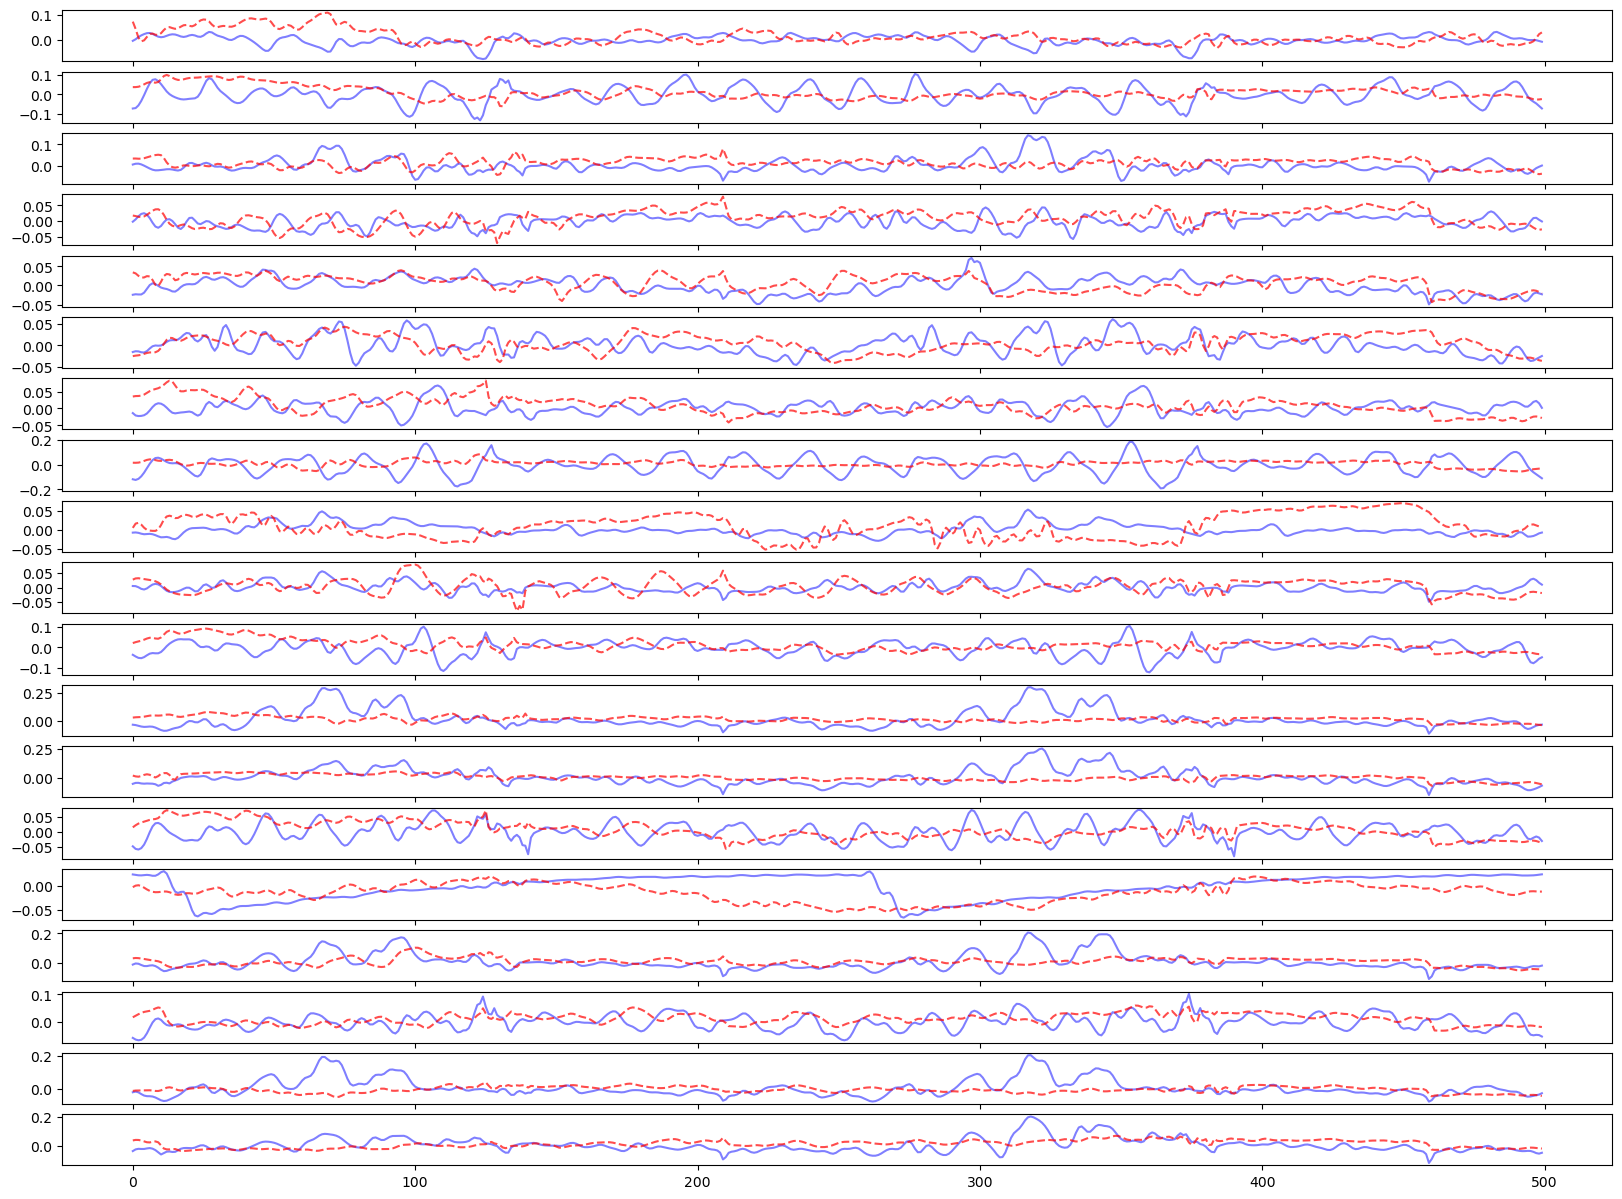

In [17]:
all_channels = schizophrenic_epochs.ch_names

channel_indices = [all_channels.index(ch) for ch in all_channels]



def plot_eeg_signals(actual_data, predicted_data, channels, title='EEG Channel Predictions'):
    plt.figure(figsize=(20,15))

    time_points = np.arange(n_times)

    for i, channel in enumerate(channels):
        plt.subplot(len(channels), 1, i + 1)
        plt.plot(time_points, actual_data[i],
                 label='Actual', color='blue', alpha=0.5)
        plt.plot(
            time_points, predicted_data[i], label='Predicted', color='red', linestyle='--', alpha=0.7)

    plt.show()

last_actual_epoch = X[-n_predictions:].reshape(
    n_predictions, n_channels, n_times)

actual_data_selected = last_actual_epoch[:, channel_indices, :].mean(axis=0)
predicted_data_selected = future_predictions[:, channel_indices, :].mean(
    axis=0)

plot_eeg_signals(actual_data_selected, predicted_data_selected,
                all_channels, title='Future Predictions for Schizophrenic Patients')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


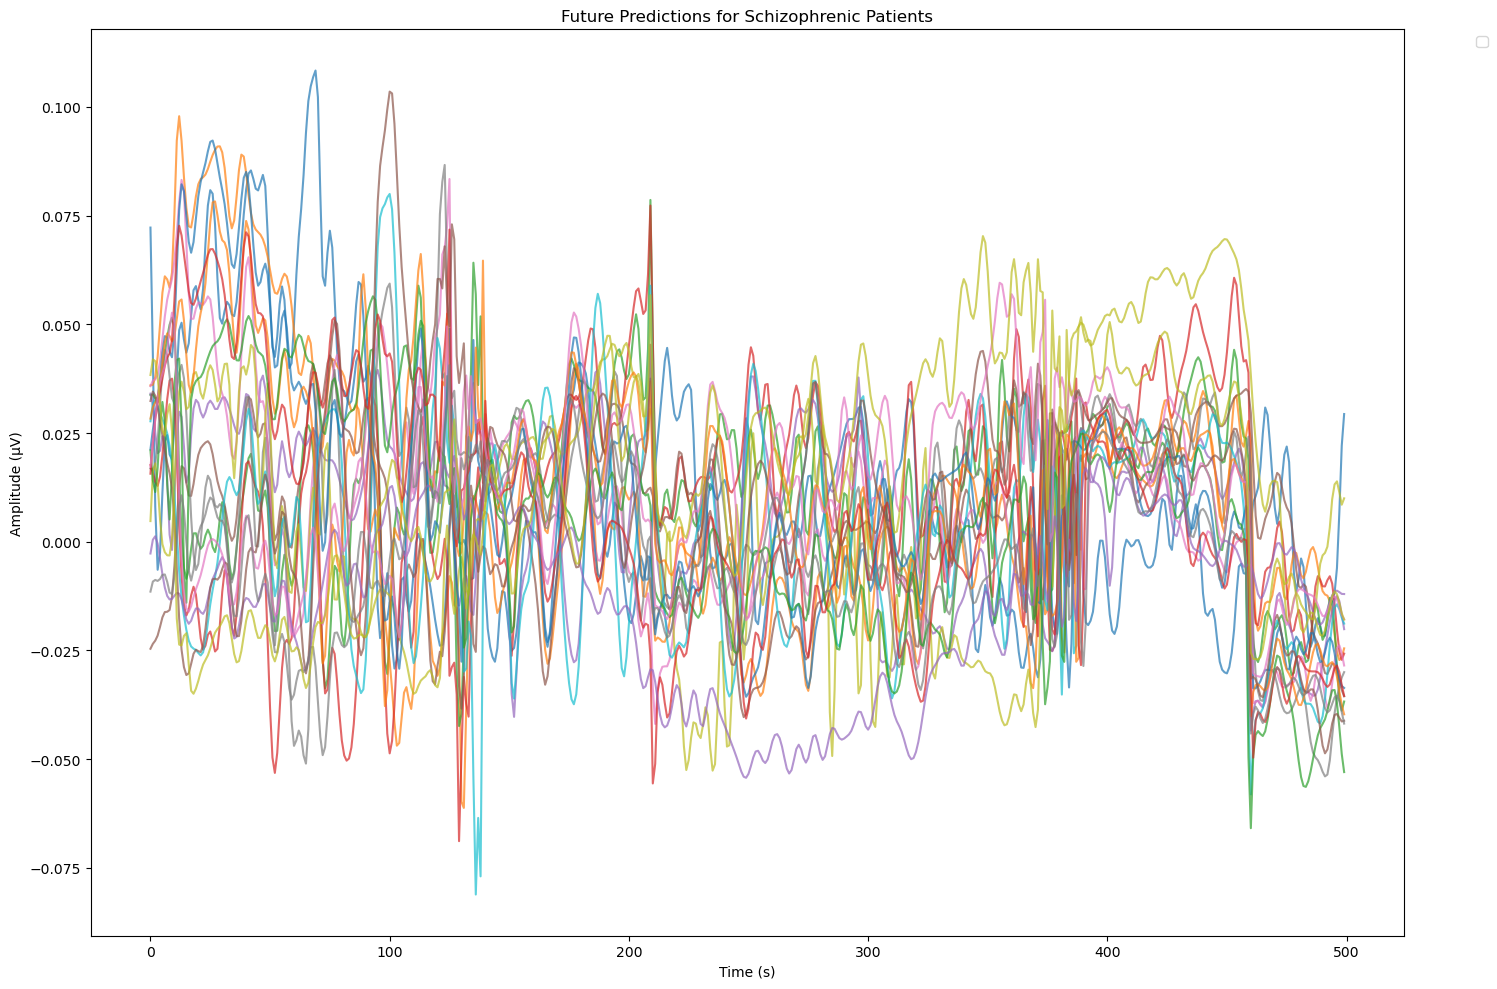

In [18]:
def plot_eeg_signals(actual_data, predicted_data, channels, title='EEG Channel Predictions'):
    plt.figure(figsize=(15, 10))
    time_points = np.arange(actual_data.shape[1])

    for i, channel in enumerate(channels):
        plt.plot(
            time_points, predicted_data[i], alpha=0.7)

    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (µV)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


all_channels = schizophrenic_epochs.ch_names
channel_indices = [all_channels.index(ch) for ch in all_channels]

last_actual_epoch = X[-n_predictions:].reshape(
    n_predictions, n_channels, n_times)

actual_data_selected = last_actual_epoch[:, channel_indices, :].mean(axis=0)
predicted_data_selected = future_predictions[:, channel_indices, :].mean(
    axis=0)

plot_eeg_signals(actual_data_selected, predicted_data_selected,
                 all_channels, title='Future Predictions for Schizophrenic Patients')